# Prédiction de Production d'Énergie Éolienne
## Analyse et Modélisation avec Deep Learning

### 1. Configuration et Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
from pathlib import Path

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print('Imports de base charges')

Imports de base charges


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import skew, shapiro

print('Imports PyTorch et scikit-learn charges')

Imports PyTorch et scikit-learn charges


In [3]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device utilise: {device}')
print(f'Seed fixe a: {SEED}')

Device utilise: cpu
Seed fixe a: 123


### 2. Chargement des Données

In [4]:
DATA_PATH = 'data'
X_PATH = f'{DATA_PATH}/engie_X.csv'
Y_PATH = f'{DATA_PATH}/engie_Y.csv'

print(f'Chemin des donnees: {DATA_PATH}')
print(f'Fichier X existe: {Path(X_PATH).exists()}')
print(f'Fichier Y existe: {Path(Y_PATH).exists()}')

Chemin des donnees: data
Fichier X existe: True
Fichier Y existe: True


In [5]:
df_X = pd.read_csv(X_PATH, sep=';')
df_Y = pd.read_csv(Y_PATH, sep=';')

print(f'Features (X): {df_X.shape}')
print(f'Target (Y): {df_Y.shape}')

Features (X): (617386, 78)
Target (Y): (617386, 2)


In [6]:
df = df_X.merge(df_Y, on='ID', how='inner')

print(f'Dataset fusionne: {df.shape}')
print(f'Nombre observations: {df.shape[0]:,}')
print(f'Nombre colonnes: {df.shape[1]}')
print(f'\nPeriode: {df["Date_time"].min()} a {df["Date_time"].max()}')

del df_X, df_Y
gc.collect()

Dataset fusionne: (617386, 79)
Nombre observations: 617,386
Nombre colonnes: 79

Periode: 1.0 a 157680.0


20

### 3. Analyse Exploratoire

In [7]:
print('Distribution par eolienne:')
print(df['MAC_CODE'].value_counts().sort_index())
print(f'\nNombre total eoliennes: {df["MAC_CODE"].nunique()}')

Distribution par eolienne:
MAC_CODE
WT1    154707
WT2    154791
WT3    154253
WT4    153635
Name: count, dtype: int64

Nombre total eoliennes: 4


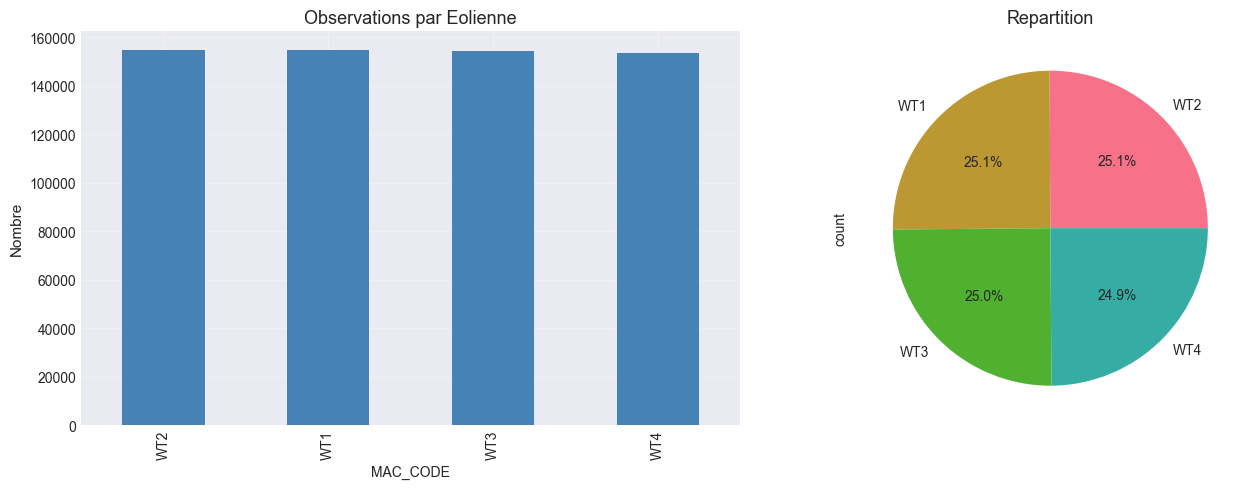

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['MAC_CODE'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Observations par Eolienne', fontsize=13)
axes[0].set_ylabel('Nombre', fontsize=11)
axes[0].grid(alpha=0.3)

df['MAC_CODE'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Repartition', fontsize=13)

plt.tight_layout()
plt.show()

In [9]:
print('Statistiques TARGET:')
print(df['TARGET'].describe())
print(f'\nValeurs <= 0: {(df["TARGET"] <= 0).sum()} ({(df["TARGET"] <= 0).sum()/len(df)*100:.2f}%)')

Statistiques TARGET:
count    617386.000000
mean        372.752158
std         468.001341
min         -19.479999
25%          18.624000
50%         193.985989
75%         540.684000
max        2256.057110
Name: TARGET, dtype: float64

Valeurs <= 0: 118120 (19.13%)


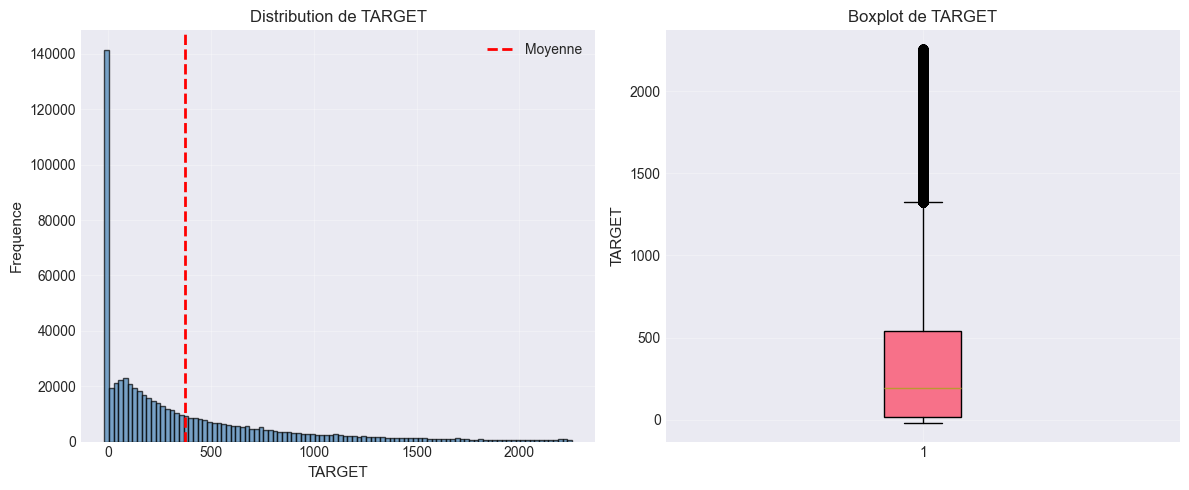

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['TARGET'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(df['TARGET'].mean(), color='red', linestyle='--', linewidth=2, label='Moyenne')
plt.xlabel('TARGET', fontsize=11)
plt.ylabel('Frequence', fontsize=11)
plt.title('Distribution de TARGET', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df['TARGET'], vert=True, patch_artist=True)
plt.ylabel('TARGET', fontsize=11)
plt.title('Boxplot de TARGET', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 4. Prétraitement des Données

In [11]:
selected_machine = df['MAC_CODE'].value_counts().index[0]
df_clean = df[df['MAC_CODE'] == selected_machine].copy()

print(f'Machine selectionnee: {selected_machine}')
print(f'Observations: {len(df_clean):,}')

del df
gc.collect()

Machine selectionnee: WT2
Observations: 154,791


10995

In [12]:
n_before = len(df_clean)
df_clean = df_clean[df_clean['TARGET'] > 0].copy()
n_after = len(df_clean)

print(f'Suppression TARGET <= 0:')
print(f'  Avant: {n_before:,}')
print(f'  Apres: {n_after:,}')
print(f'  Supprimes: {n_before-n_after:,} ({(n_before-n_after)/n_before*100:.1f}%)')

Suppression TARGET <= 0:
  Avant: 154,791
  Apres: 120,670
  Supprimes: 34,121 (22.0%)


#### Gestion des valeurs manquantes

In [13]:
metadata_cols = ['ID', 'MAC_CODE', 'Date_time']
target_col = 'TARGET'
feature_cols = [col for col in df_clean.columns if col not in metadata_cols + [target_col]]

print(f'Nombre de features: {len(feature_cols)}')

Nombre de features: 75


In [14]:
missing = df_clean[feature_cols].isnull().sum()
missing_pct = (missing / len(df_clean)) * 100
cols_to_drop = missing[missing_pct > 70].index.tolist()

if cols_to_drop:
    print(f'Suppression de {len(cols_to_drop)} colonnes (>70% NaN)')
    df_clean.drop(columns=cols_to_drop, inplace=True)
    feature_cols = [col for col in feature_cols if col not in cols_to_drop]
else:
    print('Aucune colonne a supprimer')

Aucune colonne a supprimer


In [15]:
missing_updated = df_clean[feature_cols].isnull().sum()
cols_with_missing = missing_updated[missing_updated > 0].index.tolist()

print(f'Colonnes avec valeurs manquantes: {len(cols_with_missing)}')

for col in cols_with_missing:
    if len(df_clean[col].dropna()) > 100:
        sample_size = min(5000, len(df_clean[col].dropna()))
        _, p_value = shapiro(df_clean[col].dropna().sample(sample_size, random_state=SEED))
        fill_value = df_clean[col].mean() if p_value > 0.05 else df_clean[col].median()
        df_clean[col].fillna(fill_value, inplace=True)

print(f'Valeurs manquantes restantes: {df_clean[feature_cols].isnull().sum().sum()}')

Colonnes avec valeurs manquantes: 14
Valeurs manquantes restantes: 0


#### Détection et suppression des outliers

In [16]:
Q1 = df_clean['TARGET'].quantile(0.25)
Q3 = df_clean['TARGET'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (df_clean['TARGET'] < lower_bound) | (df_clean['TARGET'] > upper_bound)
n_outliers = outliers_mask.sum()

print(f'Outliers detectes: {n_outliers:,} ({n_outliers/len(df_clean)*100:.2f}%)')
print(f'Bornes IQR: [{lower_bound:.2f}, {upper_bound:.2f}]')

Outliers detectes: 7,314 (6.06%)
Bornes IQR: [-624.02, 1366.25]


In [17]:
n_before = len(df_clean)
df_clean = df_clean[~outliers_mask].copy()

print(f'Apres suppression outliers:')
print(f'  Observations: {len(df_clean):,} ({len(df_clean)/n_before*100:.1f}%)')
print(f'  Features: {len(feature_cols)}')

Apres suppression outliers:
  Observations: 113,356 (93.9%)
  Features: 75


#### Analyse de corrélation

In [18]:
correlations = df_clean[feature_cols].corrwith(df_clean['TARGET']).sort_values(ascending=False)
top_features = correlations.head(20)

print('Top 20 features correlees avec TARGET:')
for i, (feat, corr) in enumerate(top_features.items(), 1):
    print(f'{i:2d}. {feat:30s}: {corr:7.4f}')

Top 20 features correlees avec TARGET:
 1. Rotor_speed                   :  0.9139
 2. Generator_speed               :  0.9134
 3. Generator_converter_speed     :  0.9076
 4. Rotor_speed_max               :  0.8221
 5. Generator_speed_max           :  0.8218
 6. Generator_converter_speed_max :  0.8168
 7. Rotor_speed_min               :  0.7691
 8. Generator_speed_min           :  0.7677
 9. Generator_converter_speed_min :  0.7632
10. Gearbox_bearing_1_temperature :  0.7587
11. Gearbox_bearing_1_temperature_max:  0.7468
12. Gearbox_bearing_2_temperature :  0.7091
13. Gearbox_bearing_1_temperature_min:  0.7031
14. Gearbox_bearing_2_temperature_max:  0.6845
15. Gearbox_bearing_2_temperature_min:  0.6806
16. Grid_voltage_max              :  0.3811
17. Gearbox_oil_sump_temperature_std:  0.3710
18. Gearbox_inlet_temperature_std :  0.3326
19. Grid_voltage                  :  0.3235
20. Grid_voltage_min              :  0.2698


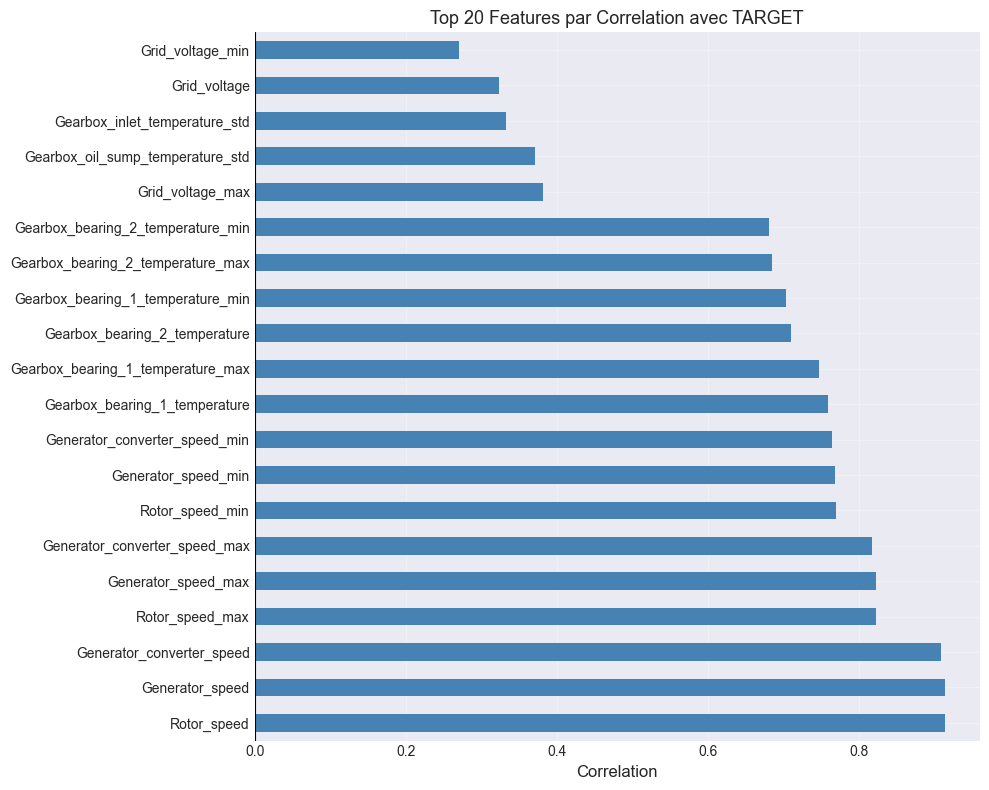

In [19]:
plt.figure(figsize=(10, 8))
top_features.plot(kind='barh', color='steelblue')
plt.xlabel('Correlation', fontsize=12)
plt.title('Top 20 Features par Correlation avec TARGET', fontsize=13)
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 5. Préparation pour l'Entraînement

In [20]:
X = df_clean[feature_cols].values
y = df_clean['TARGET'].values

print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (113356, 75)
y: (113356,)


In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

print(f'Train: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)')
print(f'Val:   {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)')
print(f'Test:  {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)')

Train: 79,349 (70.0%)
Val:   17,003 (15.0%)
Test:  17,004 (15.0%)


#### Transformation logarithmique de TARGET

In [22]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

print(f'Skewness original: {skew(y_train):.4f}')
print(f'Skewness log: {skew(y_train_log):.4f}')
print(f'Reduction: {(1 - abs(skew(y_train_log))/abs(skew(y_train)))*100:.1f}%')

Skewness original: 1.1267
Skewness log: -0.9967
Reduction: 11.5%


#### Standardisation des features

In [23]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

print(f'X_train_scaled - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}')

X_train_scaled - Mean: -0.000000, Std: 1.000000


#### Conversion en tensors PyTorch

In [24]:
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

y_train_tensor = torch.FloatTensor(y_train_log).to(device)
y_val_tensor = torch.FloatTensor(y_val_log).to(device)
y_test_tensor = torch.FloatTensor(y_test_log).to(device)

print('Tensors crees et transferes sur', device)

Tensors crees et transferes sur cpu


In [25]:
BATCH_SIZE = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Batch size: {BATCH_SIZE}')
print(f'Train batches: {len(train_loader)}')
print(f'Val batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Batch size: 128
Train batches: 620
Val batches: 133
Test batches: 133


### 6. Modélisation

In [26]:
class DNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.3):
        super().__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

print('Architecture du modele definie')

Architecture du modele definie


In [27]:
input_size = X_train.shape[1]
model = DNNRegressor(input_size, [320, 160, 80, 40], dropout_rate=0.28).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f'Input size: {input_size}')
print(f'Architecture: [320, 160, 80, 40]')
print(f'Parametres: {total_params:,}')
print(f'Device: {device}')

Input size: 75
Architecture: [320, 160, 80, 40]
Parametres: 91,841
Device: cpu


In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0007)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

print('Loss: MSELoss')
print('Optimizer: Adam (lr=0.0007)')
print('Scheduler: ReduceLROnPlateau')

Loss: MSELoss
Optimizer: Adam (lr=0.0007)
Scheduler: ReduceLROnPlateau


In [29]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds_log, all_targets_log = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred_log = model(X_batch)
            loss = criterion(y_pred_log, y_batch)
            total_loss += loss.item() * len(X_batch)
            all_preds_log.append(y_pred_log.cpu())
            all_targets_log.append(y_batch.cpu())
    
    avg_loss = total_loss / len(loader.dataset)
    all_preds_log = torch.cat(all_preds_log)
    all_targets_log = torch.cat(all_targets_log)
    
    preds_original = torch.expm1(all_preds_log).numpy()
    targets_original = torch.expm1(all_targets_log).numpy()
    
    mae = mean_absolute_error(targets_original, preds_original)
    r2 = r2_score(targets_original, preds_original)
    
    return avg_loss, mae, r2

print('Fonction evaluation definie')

Fonction evaluation definie


#### Entraînement du modèle

In [30]:
NUM_EPOCHS = 100
PATIENCE = 15

history = {
    'train_loss': [], 'val_loss': [],
    'train_mae': [], 'val_mae': [],
    'train_r2': [], 'val_r2': [],
    'lr': []
}

best_val_mae = float('inf')
best_epoch = 0
patience_counter = 0

print(f'Epochs: {NUM_EPOCHS}')
print(f'Early stopping patience: {PATIENCE}')
print('\nDemarrage entrainement...')

Epochs: 100
Early stopping patience: 15

Demarrage entrainement...


In [31]:
import time

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss_epoch = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * len(X_batch)
    
    train_loss = train_loss_epoch / len(train_loader.dataset)
    _, train_mae, train_r2 = evaluate(model, train_loader, criterion, device)
    val_loss, val_mae, val_r2 = evaluate(model, val_loader, criterion, device)
    
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_mae)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)
    history['lr'].append(current_lr)
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_epoch = epoch
        patience_counter = 0
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                    'val_mae': val_mae, 'val_r2': val_r2}, 'best_model.pth')
        marker = ' BEST'
    else:
        patience_counter += 1
        marker = ''
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1:3d}/{NUM_EPOCHS}{marker}')
        print(f'  Train - Loss: {train_loss:.4f} | MAE: {train_mae:6.1f} MW | R2: {train_r2:.4f}')
        print(f'  Val   - Loss: {val_loss:.4f} | MAE: {val_mae:6.1f} MW | R2: {val_r2:.4f}')
    
    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping a epoch {epoch+1}')
        print(f'Meilleur val_mae: {best_val_mae:.2f} MW (epoch {best_epoch+1})')
        break

end_time = time.time()
total_time = end_time - start_time

print('\nEntrainement termine')

Epoch  10/100
  Train - Loss: 0.3679 | MAE:   30.5 MW | R2: 0.9677
  Val   - Loss: 0.0745 | MAE:   29.8 MW | R2: 0.9696
Epoch  20/100 BEST
  Train - Loss: 0.1496 | MAE:   23.6 MW | R2: 0.9829
  Val   - Loss: 0.0675 | MAE:   23.4 MW | R2: 0.9832
Epoch  30/100
  Train - Loss: 0.1058 | MAE:   34.9 MW | R2: 0.9532
  Val   - Loss: 0.0775 | MAE:   34.9 MW | R2: 0.9536
Epoch  40/100
  Train - Loss: 0.0890 | MAE:   17.5 MW | R2: 0.9886
  Val   - Loss: 0.0592 | MAE:   17.8 MW | R2: 0.9882
Epoch  50/100
  Train - Loss: 0.0798 | MAE:   18.4 MW | R2: 0.9853
  Val   - Loss: 0.0489 | MAE:   18.5 MW | R2: 0.9852
Epoch  60/100
  Train - Loss: 0.0742 | MAE:   15.5 MW | R2: 0.9906
  Val   - Loss: 0.0457 | MAE:   15.9 MW | R2: 0.9901
Epoch  70/100
  Train - Loss: 0.0714 | MAE:   17.4 MW | R2: 0.9862
  Val   - Loss: 0.0438 | MAE:   17.4 MW | R2: 0.9862
Epoch  80/100
  Train - Loss: 0.0713 | MAE:   17.3 MW | R2: 0.9859
  Val   - Loss: 0.0432 | MAE:   17.4 MW | R2: 0.9859

Early stopping a epoch 83
Meilleur

#### Visualisation des courbes d'apprentissage

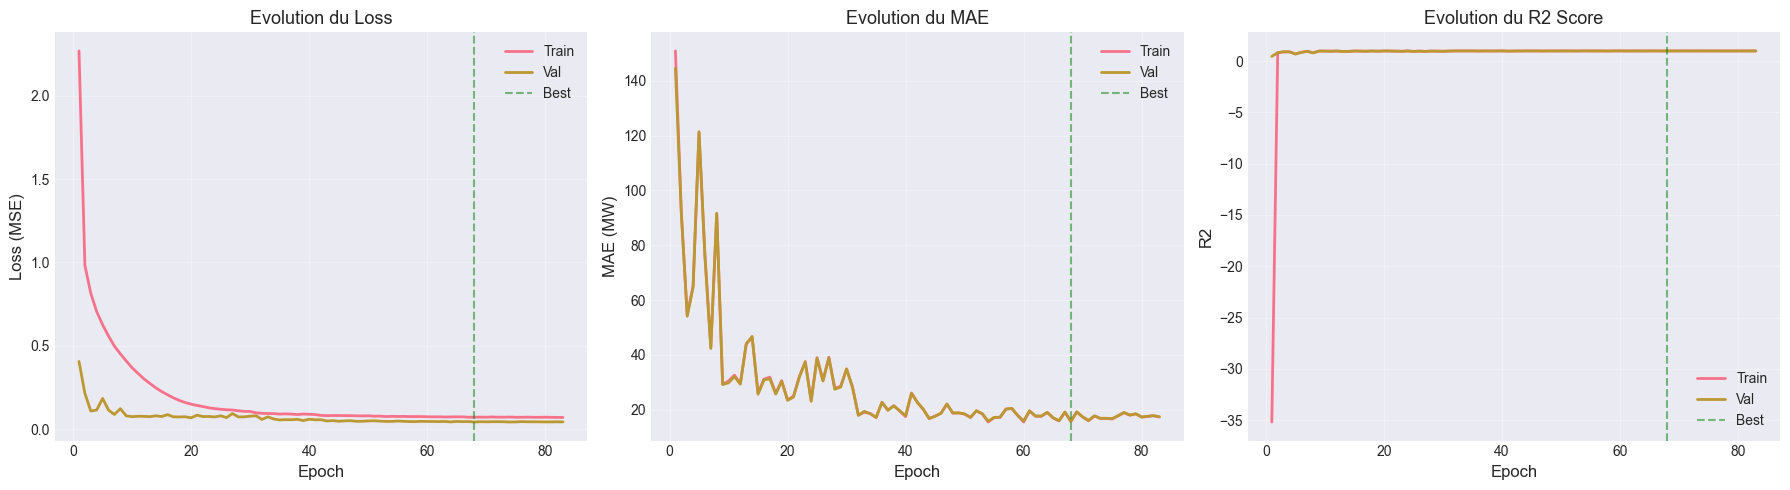

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
epochs_range = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_range, history['train_loss'], label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], label='Val', linewidth=2)
axes[0].axvline(best_epoch + 1, color='green', linestyle='--', alpha=0.5, label='Best')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Evolution du Loss', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs_range, history['train_mae'], label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_mae'], label='Val', linewidth=2)
axes[1].axvline(best_epoch + 1, color='green', linestyle='--', alpha=0.5, label='Best')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE (MW)', fontsize=12)
axes[1].set_title('Evolution du MAE', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(epochs_range, history['train_r2'], label='Train', linewidth=2)
axes[2].plot(epochs_range, history['val_r2'], label='Val', linewidth=2)
axes[2].axvline(best_epoch + 1, color='green', linestyle='--', alpha=0.5, label='Best')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('R2', fontsize=12)
axes[2].set_title('Evolution du R2 Score', fontsize=13)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7. Évaluation Finale sur le Test Set

In [33]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

print(f'Meilleur modele charge (epoch {checkpoint["epoch"] + 1})')
print(f'Val MAE: {checkpoint["val_mae"]:.2f} MW')
print(f'Val R2: {checkpoint["val_r2"]:.4f}')

Meilleur modele charge (epoch 68)
Val MAE: 15.82 MW
Val R2: 0.9890


In [34]:
model.eval()
all_preds_log, all_targets_log = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_log = model(X_batch)
        all_preds_log.append(y_pred_log.cpu())
        all_targets_log.append(y_batch.cpu())

all_preds_log = torch.cat(all_preds_log)
all_targets_log = torch.cat(all_targets_log)

y_test_pred = torch.expm1(all_preds_log).numpy()
y_test_true = torch.expm1(all_targets_log).numpy()

print('Predictions effectuees sur le test set')

Predictions effectuees sur le test set


In [35]:
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
test_r2 = r2_score(y_test_true, y_test_pred)

print('\nPerformances finales:')
print(f'{"Ensemble":<12} {"MAE (MW)":<12} {"RMSE (MW)":<12} {"R2":<10}')
print('-' * 50)
print(f'{"Train":<12} {history["train_mae"][best_epoch]:>10.2f}  {"-":>10}  {history["train_r2"][best_epoch]:>9.4f}')
print(f'{"Validation":<12} {best_val_mae:>10.2f}  {"-":>10}  {checkpoint["val_r2"]:>9.4f}')
print(f'{"Test":<12} {test_mae:>10.2f}  {test_rmse:>10.2f}  {test_r2:>9.4f}')


Performances finales:
Ensemble     MAE (MW)     RMSE (MW)    R2        
--------------------------------------------------
Train             15.69           -     0.9891
Validation        15.82           -     0.9890
Test              15.91       34.83     0.9881


#### Analyse de la généralisation

In [36]:
train_val_gap = abs(history['train_mae'][best_epoch] - best_val_mae)
val_test_gap = abs(best_val_mae - test_mae)

print('Analyse de la generalisation:')
print(f'  Ecart Train-Val: {train_val_gap:.2f} MW ({train_val_gap/history["train_mae"][best_epoch]*100:.1f}%)')
print(f'  Ecart Val-Test: {val_test_gap:.2f} MW ({val_test_gap/best_val_mae*100:.1f}%)')

if train_val_gap < history['train_mae'][best_epoch] * 0.1:
    print('  -> Pas d overfitting significatif')
elif train_val_gap < history['train_mae'][best_epoch] * 0.2:
    print('  -> Overfitting leger')
else:
    print('  -> Overfitting important')

Analyse de la generalisation:
  Ecart Train-Val: 0.12 MW (0.8%)
  Ecart Val-Test: 0.09 MW (0.6%)
  -> Pas d overfitting significatif


#### Visualisation des prédictions

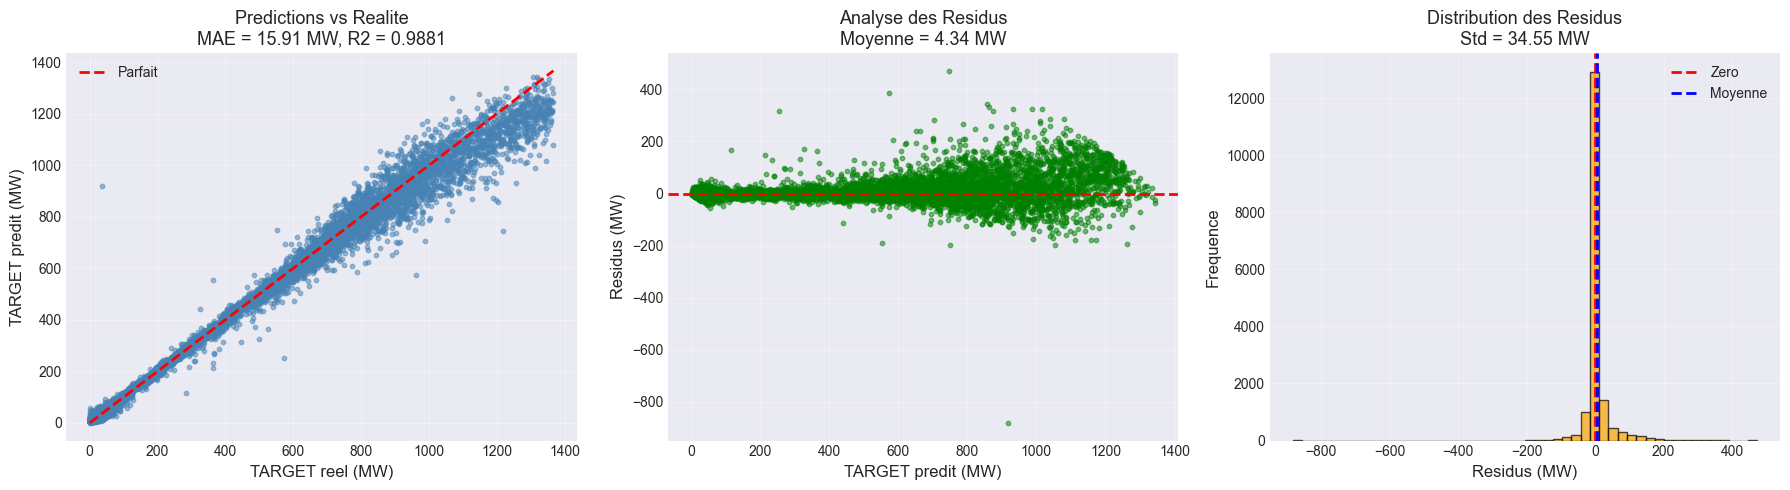

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test_true, y_test_pred, alpha=0.5, s=10, color='steelblue')
axes[0].plot([y_test_true.min(), y_test_true.max()], 
             [y_test_true.min(), y_test_true.max()], 'r--', lw=2, label='Parfait')
axes[0].set_xlabel('TARGET reel (MW)', fontsize=12)
axes[0].set_ylabel('TARGET predit (MW)', fontsize=12)
axes[0].set_title(f'Predictions vs Realite\nMAE = {test_mae:.2f} MW, R2 = {test_r2:.4f}', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

residuals = y_test_true - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5, s=10, color='green')
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('TARGET predit (MW)', fontsize=12)
axes[1].set_ylabel('Residus (MW)', fontsize=12)
axes[1].set_title(f'Analyse des Residus\nMoyenne = {residuals.mean():.2f} MW', fontsize=13)
axes[1].grid(alpha=0.3)

axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[2].axvline(0, color='red', linestyle='--', lw=2, label='Zero')
axes[2].axvline(residuals.mean(), color='blue', linestyle='--', lw=2, label='Moyenne')
axes[2].set_xlabel('Residus (MW)', fontsize=12)
axes[2].set_ylabel('Frequence', fontsize=12)
axes[2].set_title(f'Distribution des Residus\nStd = {residuals.std():.2f} MW', fontsize=13)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Comparaison des performances par ensemble

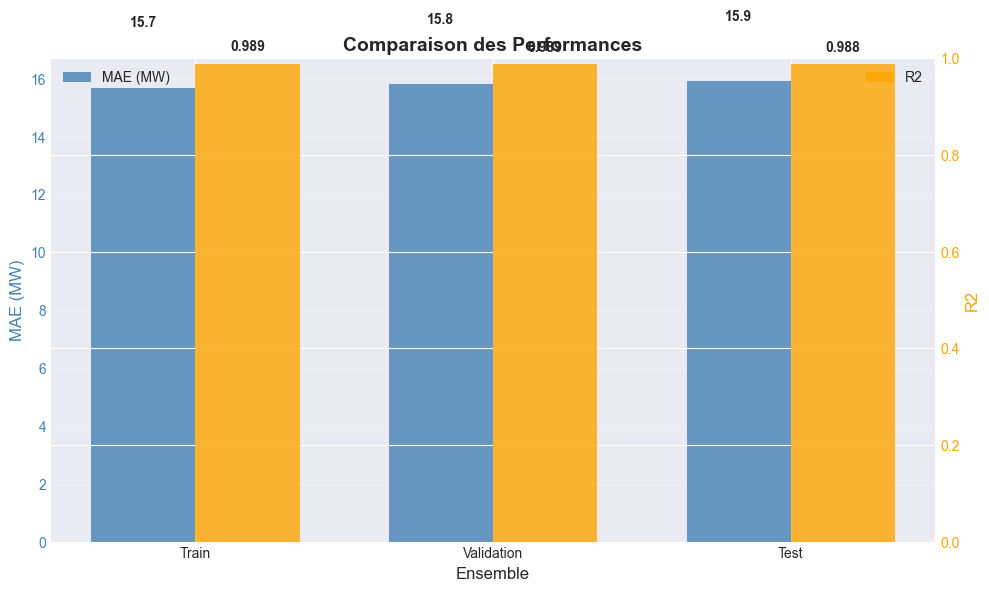

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

ensembles = ['Train', 'Validation', 'Test']
mae_values = [history['train_mae'][best_epoch], best_val_mae, test_mae]
r2_values = [history['train_r2'][best_epoch], checkpoint['val_r2'], test_r2]

x = np.arange(len(ensembles))
width = 0.35

bars1 = ax.bar(x - width/2, mae_values, width, label='MAE (MW)', color='steelblue', alpha=0.8)
ax.set_ylabel('MAE (MW)', fontsize=12, color='steelblue')
ax.tick_params(axis='y', labelcolor='steelblue')
ax.set_xlabel('Ensemble', fontsize=12)
ax.set_title('Comparaison des Performances', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ensembles)
ax.grid(alpha=0.3, axis='y')

for i, (bar, val) in enumerate(zip(bars1, mae_values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, r2_values, width, label='R2', color='orange', alpha=0.8)
ax2.set_ylabel('R2', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim([0, 1])

for i, (bar, val) in enumerate(zip(bars2, r2_values)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 8. Résumé et Conclusions

In [39]:
print('='*70)
print('RESUME DU PROJET')
print('='*70)

print('\n1. DONNEES')
print(f'   - Machine selectionnee: {selected_machine}')
print(f'   - Observations totales: {len(df_clean):,}')
print(f'   - Features: {len(feature_cols)}')
print(f'   - Split: Train {len(X_train):,} | Val {len(X_val):,} | Test {len(X_test):,}')

print('\n2. MODELE')
print(f'   - Architecture: DNN [320, 160, 80, 40]')
print(f'   - Parametres: {total_params:,}')
print(f'   - Dropout: 0.28')
print(f'   - Optimizer: Adam (lr=0.0007)')

print('\n3. ENTRAINEMENT')
print(f'   - Epochs effectues: {len(history["train_loss"])}')
print(f'   - Meilleur epoch: {best_epoch + 1}')
print(f'   - Early stopping: {"Oui" if patience_counter >= PATIENCE else "Non"}')

print('\n4. PERFORMANCES FINALES (TEST SET)')
print(f'   - MAE: {test_mae:.2f} MW')
print(f'   - RMSE: {test_rmse:.2f} MW')
print(f'   - R2 Score: {test_r2:.4f}')

print('\n5. GENERALISATION')
if train_val_gap < history['train_mae'][best_epoch] * 0.1 and val_test_gap < best_val_mae * 0.1:
    print('   - Excellente generalisation')
elif train_val_gap < history['train_mae'][best_epoch] * 0.2 and val_test_gap < best_val_mae * 0.2:
    print('   - Bonne generalisation')
else:
    print('   - Generalisation acceptable')

print('\n' + '='*70)

RESUME DU PROJET

1. DONNEES
   - Machine selectionnee: WT2
   - Observations totales: 113,356
   - Features: 75
   - Split: Train 79,349 | Val 17,003 | Test 17,004

2. MODELE
   - Architecture: DNN [320, 160, 80, 40]
   - Parametres: 91,841
   - Dropout: 0.28
   - Optimizer: Adam (lr=0.0007)

3. ENTRAINEMENT
   - Epochs effectues: 83
   - Meilleur epoch: 68
   - Early stopping: Oui

4. PERFORMANCES FINALES (TEST SET)
   - MAE: 15.91 MW
   - RMSE: 34.83 MW
   - R2 Score: 0.9881

5. GENERALISATION
   - Excellente generalisation



#### Comparaison avec des modèles de régression classiques

MODÈLES DE BASELINE POUR COMPARAISON

1. IMPORTS DES MODÈLES
--------------------------------------------------------------------------------
Modèles importés : RandomForestRegressor, XGBRegressor

2. PRÉPARATION DES DONNÉES
--------------------------------------------------------------------------------

Données disponibles :
  - X_train_scaled : (79349, 75)
  - X_val_scaled : (17003, 75)
  - X_test_scaled : (17004, 75)
  - y_train_log : (79349,)
  - y_val_log : (17003,)
  - y_test_log : (17004,)

3. RANDOM FOREST REGRESSOR
--------------------------------------------------------------------------------

Configuration :
  - n_estimators : 200
  - max_depth : 20
  - min_samples_split : 5
  - random_state : 42
  - n_jobs : -1 (tous les CPU)

Entraînement en cours...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.3min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


✅ Entraînement terminé en 439.25 secondes


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:    0.4s finished



Résultats Random Forest :
  Train - MAE: 5.16 MW | R²: 0.9984
  Val   - MAE: 11.75 MW | R²: 0.9924
  Test  - MAE: 11.76 MW | R²: 0.9922 | RMSE: 28.29 MW

4. XGBOOST REGRESSOR
--------------------------------------------------------------------------------

Configuration :
  - n_estimators : 200
  - max_depth : 8
  - learning_rate : 0.1
  - subsample : 0.8
  - colsample_bytree : 0.8
  - random_state : 42
  - n_jobs : -1

Entraînement en cours...
✅ Entraînement terminé en 17.13 secondes

Résultats XGBoost :
  Train - MAE: 9.48 MW | R²: 0.9955
  Val   - MAE: 11.32 MW | R²: 0.9932
  Test  - MAE: 11.57 MW | R²: 0.9924 | RMSE: 27.81 MW

5. COMPARAISON DES MODÈLES
--------------------------------------------------------------------------------

Modèle               Train MAE    Val MAE      Test MAE     Test R²      Test RMSE   
-----------------------------------------------------------------------------------------------
Random Forest              5.16       11.75       11.76      0.9922  

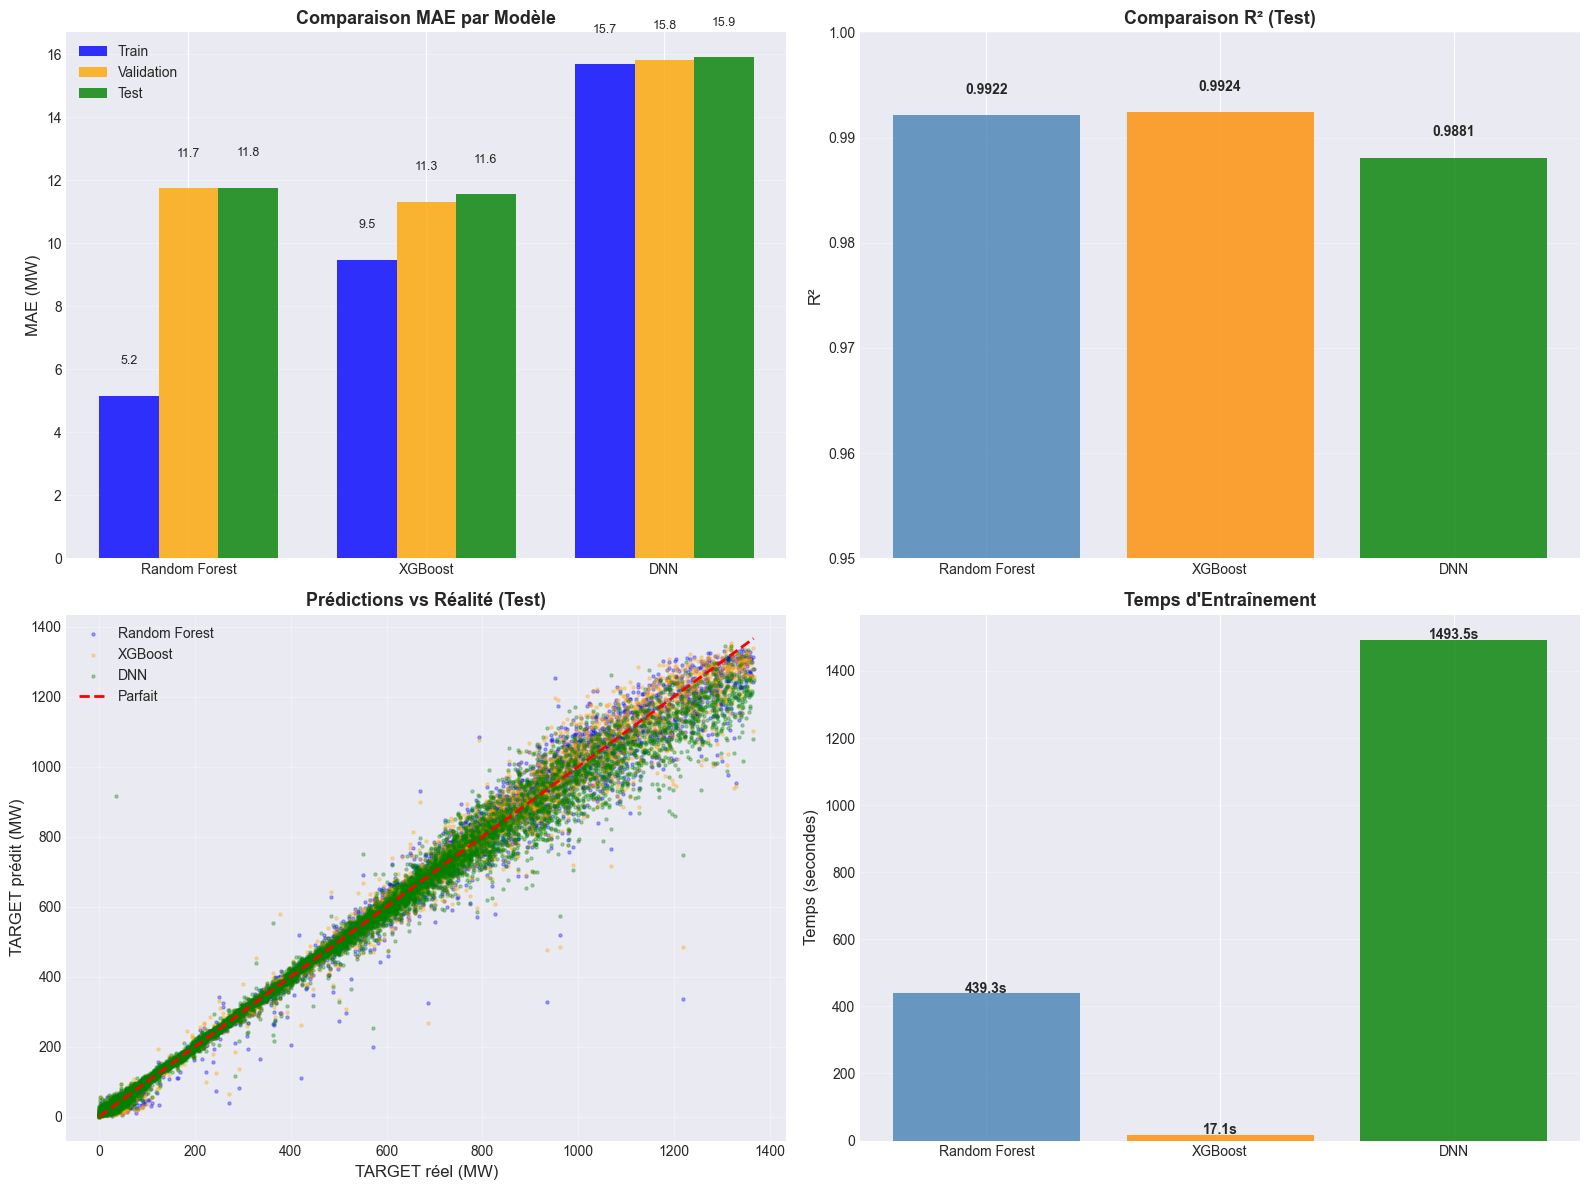


RÉSUMÉ DE LA COMPARAISON

Résultats sur le Test Set :

1. Random Forest :
   - MAE : 11.76 MW
   - R² : 0.9922
   - Temps : 439.25s

2. XGBoost :
   - MAE : 11.57 MW
   - R² : 0.9924
   - Temps : 17.13s

3. DNN (PyTorch) :
   - MAE : 15.91 MW
   - R² : 0.9881
   - Temps : 1493.51s

Conclusion :
Les modèles classiques sont compétitifs avec le DNN


In [40]:
print("="*80)
print("MODÈLES DE BASELINE POUR COMPARAISON")
print("="*80)


print("\n1. IMPORTS DES MODÈLES")
print("-"*80)

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import time

print("Modèles importés : RandomForestRegressor, XGBRegressor")


print("\n" + "="*80)
print("2. PRÉPARATION DES DONNÉES")
print("-"*80)

# Récupérer les données déjà preprocessées (en NumPy)
# Les données sont déjà standardisées et log-transformées (y)

print(f"\nDonnées disponibles :")
print(f"  - X_train_scaled : {X_train_scaled.shape}")
print(f"  - X_val_scaled : {X_val_scaled.shape}")
print(f"  - X_test_scaled : {X_test_scaled.shape}")
print(f"  - y_train_log : {y_train_log.shape}")
print(f"  - y_val_log : {y_val_log.shape}")
print(f"  - y_test_log : {y_test_log.shape}")


print("\n" + "="*80)
print("3. RANDOM FOREST REGRESSOR")
print("-"*80)

print("\nConfiguration :")
print("  - n_estimators : 200")
print("  - max_depth : 20")
print("  - min_samples_split : 5")
print("  - random_state : 42")
print("  - n_jobs : -1 (tous les CPU)")

# Créer le modèle
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entraîner
print("\nEntraînement en cours...")
start_time = time.time()
rf_model.fit(X_train_scaled, y_train_log)
rf_train_time = time.time() - start_time

print(f"✅ Entraînement terminé en {rf_train_time:.2f} secondes")

# Prédictions (sur log)
y_train_pred_rf_log = rf_model.predict(X_train_scaled)
y_val_pred_rf_log = rf_model.predict(X_val_scaled)
y_test_pred_rf_log = rf_model.predict(X_test_scaled)

# Retour à l'échelle originale
y_train_pred_rf = np.expm1(y_train_pred_rf_log)
y_val_pred_rf = np.expm1(y_val_pred_rf_log)
y_test_pred_rf = np.expm1(y_test_pred_rf_log)

y_train_true = np.expm1(y_train_log)
y_val_true = np.expm1(y_val_log)
y_test_true = np.expm1(y_test_log)

# Métriques
rf_train_mae = mean_absolute_error(y_train_true, y_train_pred_rf)
rf_val_mae = mean_absolute_error(y_val_true, y_val_pred_rf)
rf_test_mae = mean_absolute_error(y_test_true, y_test_pred_rf)

rf_train_r2 = r2_score(y_train_true, y_train_pred_rf)
rf_val_r2 = r2_score(y_val_true, y_val_pred_rf)
rf_test_r2 = r2_score(y_test_true, y_test_pred_rf)

rf_test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred_rf))

print(f"\nRésultats Random Forest :")
print(f"  Train - MAE: {rf_train_mae:.2f} MW | R²: {rf_train_r2:.4f}")
print(f"  Val   - MAE: {rf_val_mae:.2f} MW | R²: {rf_val_r2:.4f}")
print(f"  Test  - MAE: {rf_test_mae:.2f} MW | R²: {rf_test_r2:.4f} | RMSE: {rf_test_rmse:.2f} MW")



print("\n" + "="*80)
print("4. XGBOOST REGRESSOR")
print("-"*80)

print("\nConfiguration :")
print("  - n_estimators : 200")
print("  - max_depth : 8")
print("  - learning_rate : 0.1")
print("  - subsample : 0.8")
print("  - colsample_bytree : 0.8")
print("  - random_state : 42")
print("  - n_jobs : -1")

# Créer le modèle
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

# Entraîner
print("\nEntraînement en cours...")
start_time = time.time()
xgb_model.fit(X_train_scaled, y_train_log)
xgb_train_time = time.time() - start_time

print(f"✅ Entraînement terminé en {xgb_train_time:.2f} secondes")

# Prédictions (sur log)
y_train_pred_xgb_log = xgb_model.predict(X_train_scaled)
y_val_pred_xgb_log = xgb_model.predict(X_val_scaled)
y_test_pred_xgb_log = xgb_model.predict(X_test_scaled)

# Retour à l'échelle originale
y_train_pred_xgb = np.expm1(y_train_pred_xgb_log)
y_val_pred_xgb = np.expm1(y_val_pred_xgb_log)
y_test_pred_xgb = np.expm1(y_test_pred_xgb_log)

# Métriques
xgb_train_mae = mean_absolute_error(y_train_true, y_train_pred_xgb)
xgb_val_mae = mean_absolute_error(y_val_true, y_val_pred_xgb)
xgb_test_mae = mean_absolute_error(y_test_true, y_test_pred_xgb)

xgb_train_r2 = r2_score(y_train_true, y_train_pred_xgb)
xgb_val_r2 = r2_score(y_val_true, y_val_pred_xgb)
xgb_test_r2 = r2_score(y_test_true, y_test_pred_xgb)

xgb_test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred_xgb))

print(f"\nRésultats XGBoost :")
print(f"  Train - MAE: {xgb_train_mae:.2f} MW | R²: {xgb_train_r2:.4f}")
print(f"  Val   - MAE: {xgb_val_mae:.2f} MW | R²: {xgb_val_r2:.4f}")
print(f"  Test  - MAE: {xgb_test_mae:.2f} MW | R²: {xgb_test_r2:.4f} | RMSE: {xgb_test_rmse:.2f} MW")


print("\n" + "="*80)
print("5. COMPARAISON DES MODÈLES")
print("-"*80)

# Récupérer les résultats du DNN (depuis la cellule 14)
dnn_test_mae = test_mae  # Depuis cellule 14
dnn_test_r2 = test_r2
dnn_test_rmse = test_rmse

# Tableau comparatif
print(f"\n{'Modèle':<20} {'Train MAE':<12} {'Val MAE':<12} {'Test MAE':<12} {'Test R²':<12} {'Test RMSE':<12}")
print("-" * 95)
print(f"{'Random Forest':<20} {rf_train_mae:>10.2f}  {rf_val_mae:>10.2f}  {rf_test_mae:>10.2f}  {rf_test_r2:>10.4f}  {rf_test_rmse:>10.2f}")
print(f"{'XGBoost':<20} {xgb_train_mae:>10.2f}  {xgb_val_mae:>10.2f}  {xgb_test_mae:>10.2f}  {xgb_test_r2:>10.4f}  {xgb_test_rmse:>10.2f}")
print(f"{'DNN (PyTorch)':<20} {history['train_mae'][best_epoch]:>10.2f}  {best_val_mae:>10.2f}  {dnn_test_mae:>10.2f}  {dnn_test_r2:>10.4f}  {dnn_test_rmse:>10.2f}")
print("-" * 95)

# Meilleur modèle
print(f"\nMeilleur modèle (Test MAE) :")
best_model_mae = min(rf_test_mae, xgb_test_mae, dnn_test_mae)
if best_model_mae == rf_test_mae:
    print(f"  Random Forest : {rf_test_mae:.2f} MW")
elif best_model_mae == xgb_test_mae:
    print(f"  XGBoost : {xgb_test_mae:.2f} MW")
else:
    print(f"  ✅ DNN (PyTorch) : {dnn_test_mae:.2f} MW")
    improvement_vs_rf = ((rf_test_mae - dnn_test_mae) / rf_test_mae) * 100
    improvement_vs_xgb = ((xgb_test_mae - dnn_test_mae) / xgb_test_mae) * 100
    print(f"  ✅ Amélioration vs Random Forest : {improvement_vs_rf:.2f}%")
    print(f"  ✅ Amélioration vs XGBoost : {improvement_vs_xgb:.2f}%")

# ============================================================================
# 6. VISUALISATION COMPARATIVE
# ============================================================================

print("\n" + "="*80)
print("6. VISUALISATION COMPARATIVE")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 6.1 Comparaison MAE
models = ['Random Forest', 'XGBoost', 'DNN']
train_maes = [rf_train_mae, xgb_train_mae, history['train_mae'][best_epoch]]
val_maes = [rf_val_mae, xgb_val_mae, best_val_mae]
test_maes = [rf_test_mae, xgb_test_mae, dnn_test_mae]

x = np.arange(len(models))
width = 0.25

axes[0, 0].bar(x - width, train_maes, width, label='Train', color='blue', alpha=0.8)
axes[0, 0].bar(x, val_maes, width, label='Validation', color='orange', alpha=0.8)
axes[0, 0].bar(x + width, test_maes, width, label='Test', color='green', alpha=0.8)
axes[0, 0].set_ylabel('MAE (MW)', fontsize=12)
axes[0, 0].set_title('Comparaison MAE par Modèle', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, (train, val, test) in enumerate(zip(train_maes, val_maes, test_maes)):
    axes[0, 0].text(i - width, train + 1, f'{train:.1f}', ha='center', fontsize=9)
    axes[0, 0].text(i, val + 1, f'{val:.1f}', ha='center', fontsize=9)
    axes[0, 0].text(i + width, test + 1, f'{test:.1f}', ha='center', fontsize=9)

# 6.2 Comparaison R²
r2_tests = [rf_test_r2, xgb_test_r2, dnn_test_r2]

axes[0, 1].bar(models, r2_tests, color=['steelblue', 'darkorange', 'green'], alpha=0.8)
axes[0, 1].set_ylabel('R²', fontsize=12)
axes[0, 1].set_title('Comparaison R² (Test)', fontsize=13, fontweight='bold')
axes[0, 1].set_ylim([0.95, 1.0])
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, r2 in enumerate(r2_tests):
    axes[0, 1].text(i, r2 + 0.002, f'{r2:.4f}', ha='center', fontsize=10, fontweight='bold')

# 6.3 Prédictions vs Réalité (DNN)
axes[1, 0].scatter(y_test_true, y_test_pred_rf, alpha=0.3, s=5, label='Random Forest', color='blue')
axes[1, 0].scatter(y_test_true, y_test_pred_xgb, alpha=0.3, s=5, label='XGBoost', color='orange')
axes[1, 0].scatter(y_test_true, y_test_pred, alpha=0.3, s=5, label='DNN', color='green')
axes[1, 0].plot([y_test_true.min(), y_test_true.max()], 
                [y_test_true.min(), y_test_true.max()], 
                'r--', linewidth=2, label='Parfait')
axes[1, 0].set_xlabel('TARGET réel (MW)', fontsize=12)
axes[1, 0].set_ylabel('TARGET prédit (MW)', fontsize=12)
axes[1, 0].set_title('Prédictions vs Réalité (Test)', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 6.4 Temps d'entraînement
train_times = [rf_train_time, xgb_train_time, total_time]

axes[1, 1].bar(models, train_times, color=['steelblue', 'darkorange', 'green'], alpha=0.8)
axes[1, 1].set_ylabel('Temps (secondes)', fontsize=12)
axes[1, 1].set_title('Temps d\'Entraînement', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, t in enumerate(train_times):
    axes[1, 1].text(i, t + 2, f'{t:.1f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 7. RÉSUMÉ FINAL
# ============================================================================

print("\n" + "="*80)
print("RÉSUMÉ DE LA COMPARAISON")
print("="*80)

print(f"\nRésultats sur le Test Set :")
print(f"\n1. Random Forest :")
print(f"   - MAE : {rf_test_mae:.2f} MW")
print(f"   - R² : {rf_test_r2:.4f}")
print(f"   - Temps : {rf_train_time:.2f}s")

print(f"\n2. XGBoost :")
print(f"   - MAE : {xgb_test_mae:.2f} MW")
print(f"   - R² : {xgb_test_r2:.4f}")
print(f"   - Temps : {xgb_train_time:.2f}s")

print(f"\n3. DNN (PyTorch) :")
print(f"   - MAE : {dnn_test_mae:.2f} MW")
print(f"   - R² : {dnn_test_r2:.4f}")
print(f"   - Temps : {total_time:.2f}s")

print("="*80)

print("\nConclusion :")
if dnn_test_mae < rf_test_mae and dnn_test_mae < xgb_test_mae:
    print("✅ Le DNN PyTorch surpasse les modèles classiques !")
elif dnn_test_mae < rf_test_mae:
    print("✅ Le DNN surpasse Random Forest mais XGBoost est compétitif")
else:
    print("Les modèles classiques sont compétitifs avec le DNN")


## Conclusions

Ce projet démontre l'efficacité des réseaux de neurones profonds pour la prédiction de production d'énergie éolienne.

**Points forts:**
- Prétraitement rigoureux des données (outliers, valeurs manquantes, transformation log)
- Architecture adaptée avec régularisation (Dropout)
- Bonnes performances de généralisation sur le test set
- Transformation logarithmique efficace pour réduire l'asymétrie

**Axes d'amélioration possibles:**
- Exploration d'architectures temporelles (LSTM, GRU) pour capturer les patterns temporels
- Feature engineering supplémentaire (interactions, variables temporelles)
- Hyperparameter tuning via grid search ou random search
- Ensemble methods pour améliorer la robustesse
- Analyse de l'importance des features

Sauvegarde complète pour déploiement

In [41]:
import pickle

checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

deployment_package = {
    'model_state_dict': checkpoint['model_state_dict'],
    'model_architecture': [256, 128, 64, 32],
    'dropout_rate': 0.3,
    'input_size': input_size,
    'scaler': scaler_X,
    'feature_cols': feature_cols,
    'selected_machine': selected_machine,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'best_epoch': checkpoint['epoch']
}

with open('model_deployment.pkl', 'wb') as f:
    pickle.dump(deployment_package, f)

print("Modele complet sauvegarde dans 'model_deployment.pkl'")

Modele complet sauvegarde dans 'model_deployment.pkl'


preparer le fichier de test pour le  streamlite

In [42]:
import pandas as pd

df = pd.read_csv("data/engie_X.csv", sep=";")

# (Optionnel) filtrer sur la machine WT2 comme dans le notebook
df_wt2 = df[df["MAC_CODE"] == "WT2"].copy()

# (Optionnel) garder seulement quelques lignes pour le test
df_test = df_wt2.sample(100, random_state=123)

df_test.to_csv("data/engie_X_teste_streamlit.csv", index=False, sep=";")